# Text generation using GPT2


## Load data and get convesations

In [59]:
!pip install -q convokit 
from convokit import Corpus, download
import numpy as np
import pandas as pd
corpus = Corpus(filename=download("movie-corpus"))

In [60]:
from tqdm import tqdm
def get_movie_utt_dic(corpus):
    '''
    get the dictionary of movies that map movies to corresponding utterances. 
    In chronological order. 
    '''
    movie_utt_dic = {}
    movie_idx_name = {}
    for utt in tqdm(corpus.iter_utterances()):
        if utt.meta['movie_id'] not in movie_utt_dic:
            movie_utt_dic[utt.meta['movie_id']] = []
            movie_idx_name[utt.meta['movie_id']] = utt.speaker.meta['movie_name']
        movie_utt_dic[utt.meta['movie_id']].append(int(utt.id[1:]))
    
    for movie, utt_lst in tqdm(movie_utt_dic.items()):
        id_lst = sorted(utt_lst)
        movie_utt_dic[movie] =  ['L' + str(i) for i in id_lst]
    
    return movie_utt_dic, movie_idx_name
        
movie_utt_dic, movie_idx_name = get_movie_utt_dic(corpus)

304713it [00:00, 529600.51it/s]
100%|██████████| 617/617 [00:00<00:00, 5400.64it/s]


In [63]:
conv = {}
conv_speaker = {}
movie_dialog = {}

for movie_id, utt_ids in movie_utt_dic.items():
  movie_dialog[movie_id] = ''
  for utt_id in utt_ids:
    utt = corpus.get_utterance(utt_id)
    movie_dialog[movie_id] += utt.text + ''
    conv_id = utt.conversation_id
    
    if conv_id not in conv:
      conv[conv_id] = []
      conv_speaker[conv_id] = []
    conv[conv_id].append(utt.text)
    conv_speaker[conv_id].append(utt.speaker.id)

In [ ]:
conv_gender_proportion = {}

for conv_id, speakers in conv_speaker.items():
  genders = []
  for speaker_id in speakers:
    gender = corpus.get_speaker(speaker_id).meta['gender']
    genders.append(gender)
  
  female_proportion = sum([1 for gender in genders if gender=='f'])/len(genders)
  conv_gender_proportion[conv_id] = female_proportion

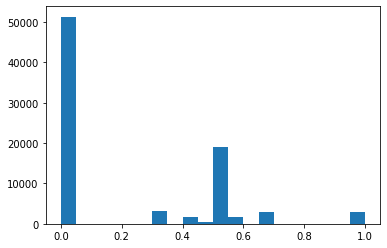

In [ ]:
import matplotlib.pyplot as plt
plt.hist(conv_gender_proportion.values(), 20);

In [ ]:
conv_only_male = []
conv_less_female = []
conv_more_female = []
conv_all = []
for conv_id, gender_proportion in conv_gender_proportion.items():
  conv_all.append(' '.join(conv[conv_id]))
  if gender_proportion == 0:
    conv_only_male.append(' '.join(conv[conv_id]))
  elif gender_proportion <=0.5:
    conv_less_female.append(' '.join(conv[conv_id]))
  else:
    conv_more_female.append(' '.join(conv[conv_id]))

In [ ]:
df_only_male = pd.DataFrame(conv_only_male)
df_only_male = df_only_male.sample(len(conv_more_female))
# our puropse is do abstraction. So we want overfit. Here we don't do train test split.

In [ ]:
df_only_male.to_csv(r'only_male', header=None, index=None, sep=' ', mode='a')

In [ ]:
df_more_female = pd.DataFrame(conv_more_female)
# our puropse is do abstraction. So we want overfit. Here we don't do train test split.

In [ ]:
df_more_female.to_csv(r'more_female', header=None, index=None, sep=' ', mode='a')

In [ ]:
df_all = pd.DataFrame(conv_all)
# our puropse is do abstraction. So we want overfit. Here we don't do train test split.

In [ ]:
df_all.to_csv(r'all_conv', header=None, index=None, sep=' ', mode='a')

In [65]:
df_movies = pd.DataFrame(list(movie_dialog.values()))

In [66]:
df_movies.to_csv(r'all_movies', header=None, index=None, sep=' ', mode='a')

## Train two GPT models 

In [67]:
!pip install -q transformers
from transformers import AutoModelWithLMHead, AutoTokenizer

### Model only use conversations having male characters involved

In [ ]:
!python /content/drive/MyDrive/Colab\ Notebooks/Thinking_with_DL/Final/run_language_modeling.py --per_gpu_train_batch_size=2 --output_dir=/content/drive/MyDrive/Colab\ Notebooks/Thinking_with_DL/Final/output_gpt_only_male --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=only_male

In [ ]:
dir = '/content/drive/MyDrive/Colab Notebooks/Thinking_with_DL/Final/output_gpt_only_male'
tokenizer_gpt = AutoTokenizer.from_pretrained(dir)
model_gpt = AutoModelWithLMHead.from_pretrained(dir)

# here we use the two sentences of introduction of this movie from IMDb as prompts.
sequence_man = "A man stays at home, and he plans to"
sequence_woman = "A woman stays at home, and she plans to"

sequence_man_2 = "A man falls in love with a woman, and he plans to"
sequence_woman_2 = "A woman falls in love with a man, and she plans to"

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:925: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [ ]:
input = tokenizer_gpt.encode(sequence_man, return_tensors="pt")
generated = model_gpt.generate(input, max_length=200, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

A man stays at home, and he plans to kill me. I'm not going to kill you. I'm not going to kill you. I'm not going to kill you. I'm not going to kill you. I'm not going to kill you. I'm not going to kill you. I'm not going to kill you. I'm not going to kill you. I'm not going to kill you. I'm not going to kill you. I'm not going to kill you. I'm not going to kill you. I'm not going to kill you. I'm not going to kill you. I'm not going to kill you. I'm not going to kill you. I'm not going to kill you. I'm not going to kill you. I'm not going to kill you. I'm not going to kill you. I'm not going to kill you. I'm not going to kill you. I'm not going to kill you. I'm not


In [ ]:
input = tokenizer_gpt.encode(sequence_woman, return_tensors="pt")
generated = model_gpt.generate(input, max_length=200, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

A woman stays at home, and she plans to go to the hospital. She's not going to be able to go to the hospital. She's going to be in the hospital. She's going to be in the hospital. She's going to be in the hospital. She's going to be in the hospital. She's going to be in the hospital. She's going to be in the hospital. She's going to be in the hospital. She's going to be in the hospital. She's going to be in the hospital. She's going to be in the hospital. She's going to be in the hospital. She's going to be in the hospital. She's going to be in the hospital. She's going to be in the hospital. She's going to be in the hospital. She's going to be in the hospital. She's going to be in the hospital. She's going to be in the hospital. She's going to be in the hospital. She


In [ ]:
input = tokenizer_gpt.encode(sequence_man_2, return_tensors="pt")
generated = model_gpt.generate(input, max_length=200, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

A man falls in love with a woman, and he plans to kill her. He's a man who's been married for twenty years. He's a man who's been married for twenty years. He's a man who's been married for twenty years. He's a man who's been married for twenty years. He's a man who's been married for twenty years. He's a man who's been married for twenty years. He's a man who's been married for twenty years. He's a man who's been married for twenty years. He's a man who's been married for twenty years. He's a man who's been married for twenty years. He's a man who's been married for twenty years. He's a man who's been married for twenty years. He's a man who's been married for twenty years. He's a man who's been married for twenty years. He's a man who's been married for twenty years. He's a man


In [ ]:
input = tokenizer_gpt.encode(sequence_woman_2, return_tensors="pt")
generated = model_gpt.generate(input, max_length=200, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

A woman falls in love with a man, and she plans to marry him. She's a good girl, but she's not a good husband. She's a good girl, but she's not a good husband. She's a good girl, but she's not a good husband. She's a good girl, but she's not a good husband. She's a good girl, but she's not a good husband. She's a good girl, but she's not a good husband. She's a good girl, but she's not a good husband. She's a good girl, but she's not a good husband. She's a good girl, but she's not a good husband. She's a good girl, but she's not a good husband. She's a good girl, but she's not a good husband. She's a good girl, but she's not a good husband. She's a good girl, but she's not a good husband. She's


### Model only use conversations having more female characters involved

In [ ]:
!python /content/drive/MyDrive/Colab\ Notebooks/Thinking_with_DL/Final/run_language_modeling.py --per_gpu_train_batch_size=2 --output_dir=/content/drive/MyDrive/Colab\ Notebooks/Thinking_with_DL/Final/output_gpt_more_female --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=more_female


In [ ]:
dir = '/content/drive/MyDrive/Colab Notebooks/Thinking_with_DL/Final/output_gpt_more_female'
tokenizer_gpt = AutoTokenizer.from_pretrained(dir)
model_gpt = AutoModelWithLMHead.from_pretrained(dir)

sequence_man = "A man stays at home, and he plans to"
sequence_woman = "A woman stays at home, and she plans to"

sequence_man_2 = "A man falls in love with a woman, and he plans to"
sequence_woman_2 = "A woman falls in love with a man, and she plans to"

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:925: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [ ]:
input = tokenizer_gpt.encode(sequence_man, return_tensors="pt")
generated = model_gpt.generate(input, max_length=200, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

A man stays at home, and he plans to kill himself. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He's a good guy. He


In [ ]:
input = tokenizer_gpt.encode(sequence_woman, return_tensors="pt")
generated = model_gpt.generate(input, max_length=200, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

A woman stays at home, and she plans to go to the hospital. She's not going to be able to go to the hospital. She's going to be in a coma. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She's going to die. She


In [ ]:
input = tokenizer_gpt.encode(sequence_man_2, return_tensors="pt")
generated = model_gpt.generate(input, max_length=200, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

A man falls in love with a woman, and he plans to marry her. He's a man, and he's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a man. He's a


In [ ]:
input = tokenizer_gpt.encode(sequence_woman_2, return_tensors="pt")
generated = model_gpt.generate(input, max_length=200, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

A woman falls in love with a man, and she plans to marry him. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin. She's a virgin


### Model use ALL conversations

In [ ]:
!python /content/drive/MyDrive/Colab\ Notebooks/Thinking_with_DL/Final/run_language_modeling.py --per_gpu_train_batch_size=2 --output_dir=/content/drive/MyDrive/Colab\ Notebooks/Thinking_with_DL/Final/output_gpt_all --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=all_conv


In [ ]:
dir = '/content/drive/MyDrive/Colab Notebooks/Thinking_with_DL/Final/output_gpt_all'
tokenizer_gpt = AutoTokenizer.from_pretrained(dir)
model_gpt = AutoModelWithLMHead.from_pretrained(dir)

sequence_man = "A man stays at home, and he plans to"
sequence_woman = "A woman stays at home, and she plans to"

sequence_man_2 = "A man falls in love with a woman, and he plans to"
sequence_woman_2 = "A woman falls in love with a man, and she plans to"

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:925: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [ ]:
input = tokenizer_gpt.encode(sequence_man, return_tensors="pt")
generated = model_gpt.generate(input, max_length=200, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

A man stays at home, and he plans to kill himself.  He's a man who's been living in a house for a long time.  He's a man who's been living in a house for a long time.  He's a man who's been living in a house for a long time.  He's a man who's been living in a house for a long time.  He's a man who's been living in a house for a long time.  He's a man who's been living in a house for a long time.  He's a man who's been living in a house for a long time.  He's a man who's been living in a house for a long time.  He's a man who's been living in a house for a long time.  He's a man who's been living in a house for a long time.  He's a man who's been living in a house for a long time.


In [ ]:
input = tokenizer_gpt.encode(sequence_woman, return_tensors="pt")
generated = model_gpt.generate(input, max_length=200, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

A woman stays at home, and she plans to go to the hospital.  She's not going to be able to go to the hospital.  She's going to be in a coma.  She's going to die.  She's going to die.  She's going to die.  She's going to die.  She's going to die.  She's going to die.  She's going to die.  She's going to die.  She's going to die.  She's going to die.  She's going to die.  She's going to die.  She's going to die.  She's going to die.  She's going to die.  She's going to die.  She's going to die.  She's going to die.  She's going to die.  She's going to die.  She's going to die.  She's going to die.  She's going to die.


In [ ]:
input = tokenizer_gpt.encode(sequence_man_2, return_tensors="pt")
generated = model_gpt.generate(input, max_length=200, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

A man falls in love with a woman, and he plans to marry her.  He's a man, and he's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a man.  He's a


In [ ]:
input = tokenizer_gpt.encode(sequence_woman_2, return_tensors="pt")
generated = model_gpt.generate(input, max_length=200, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

A woman falls in love with a man, and she plans to marry him.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a


### Model uses complete movie dialogs

In [68]:
!python /content/drive/MyDrive/Colab\ Notebooks/Thinking_with_DL/Final/run_language_modeling.py --per_gpu_train_batch_size=2 --output_dir=/content/drive/MyDrive/Colab\ Notebooks/Thinking_with_DL/Final/output_gpt_complete --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=all_movies

05/31/2022 06:41:23 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
05/31/2022 06:41:32 - INFO - __main__ -   Training/evaluation parameters Namespace(adam_epsilon=1e-08, block_size=1024, cache_dir='', config_name='', device=device(type='cuda'), do_eval=False, do_lower_case=False, do_train=True, eval_all_checkpoints=False, eval_data_file=None, evaluate_during_training=False, fp16=False, fp16_opt_level='O1', gradient_accumulation_steps=1, learning_rate=5e-05, local_rank=-1, logging_steps=50, max_grad_norm=1.0, max_steps=-1, mlm=False, mlm_probability=0.15, model_name_or_path='gpt2', model_type='gpt2', n_gpu=1, no_cuda=False, num_train_epochs=1.0, num_warmup_steps=0, output_dir='/content/drive/MyDrive/Colab Notebooks/Thinking_with_DL/Final/output_gpt_complete', overwrite_cache=False, overwrite_output_dir=False, per_gpu_eval_batch_size=1, per_gpu_train_batch_size=2, save_steps=50, save_total_limit=None, seed=42, serve

In [69]:
dir = '/content/drive/MyDrive/Colab Notebooks/Thinking_with_DL/Final/output_gpt_complete'
tokenizer_gpt = AutoTokenizer.from_pretrained(dir)
model_gpt = AutoModelWithLMHead.from_pretrained(dir)

# here we use the two sentences of introduction of this movie from IMDb as prompts.
sequence_man = "A man stays at home, and he plans to"
sequence_woman = "A woman stays at home, and she plans to"

sequence_man_2 = "A man falls in love with a woman, and he plans to"
sequence_woman_2 = "A woman falls in love with a man, and she plans to"

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:925: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [70]:
input = tokenizer_gpt.encode(sequence_man, return_tensors="pt")
generated = model_gpt.generate(input, max_length=200, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

A man stays at home, and he plans to kill himself.  He's a man who's been in the business for twenty years.  He's a man who's been in the business for twenty years.  He's a man who's been in the business for twenty years.  He's a man who's been in the business for twenty years.  He's a man who's been in the business for twenty years.  He's a man who's been in the business for twenty years.  He's a man who's been in the business for twenty years.  He's a man who's been in the business for twenty years.  He's a man who's been in the business for twenty years.  He's a man who's been in the business for twenty years.  He's a man who's been in the business for twenty years.  He's a man who's been in the business for twenty years.  He's a man who's


In [71]:
input = tokenizer_gpt.encode(sequence_woman, return_tensors="pt")
generated = model_gpt.generate(input, max_length=200, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

A woman stays at home, and she plans to go to the hospital.  She's going to be fine.  She's going to be fine.  She's going to be fine.  She's going to be fine.  She's going to be fine.  She's going to be fine.  She's going to be fine.  She's going to be fine.  She's going to be fine.  She's going to be fine.  She's going to be fine.  She's going to be fine.  She's going to be fine.  She's going to be fine.  She's going to be fine.  She's going to be fine.  She's going to be fine.  She's going to be fine.  She's going to be fine.  She's going to be fine.  She's going to be fine.  She's going to be fine.  She's going to be fine. 


In [72]:
input = tokenizer_gpt.encode(sequence_man_2, return_tensors="pt")
generated = model_gpt.generate(input, max_length=200, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

A man falls in love with a woman, and he plans to marry her.  He's a man who's been married for twenty years.  He's a man who's been married for twenty years.  He's a man who's been married for twenty years.  He's a man who's been married for twenty years.  He's a man who's been married for twenty years.  He's a man who's been married for twenty years.  He's a man who's been married for twenty years.  He's a man who's been married for twenty years.  He's a man who's been married for twenty years.  He's a man who's been married for twenty years.  He's a man who's been married for twenty years.  He's a man who's been married for twenty years.  He's a man who's been married for twenty years.  He's a man who's been married for twenty years.  He


In [73]:
input = tokenizer_gpt.encode(sequence_woman_2, return_tensors="pt")
generated = model_gpt.generate(input, max_length=200, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

A woman falls in love with a man, and she plans to marry him.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a virgin.  She's a


Stigmatize